In [125]:
import torch
from sklearn.model_selection import train_test_split

from sampler.spray_sampler import SpraySampler

directory = "res/sprays"
spray_sampler = SpraySampler(directory)
x, y = spray_sampler.sample(16_000)

k = 4
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=410)
X_train = torch.stack([
    torch.stack(
        [torch.from_numpy(a)[1:k + 1, :], torch.from_numpy(b)[1:k + 1, :]]
    ).flatten(start_dim=0)
    for (a, b) in X_train
])
X_test = torch.stack([
    torch.stack(
        [torch.from_numpy(a)[1:k + 1, :], torch.from_numpy(b)[1:k + 1, :]]
    ).flatten(start_dim=0)
    for (a, b) in X_test
])

print(X_train.shape, X_test.shape)

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

print(y_train.shape, y_test.shape)

# print(len(X_train), type(X_train[0][0]), y_train.shape)
# print(len(X_test), type(X_test[0][0]), y_test.shape)

torch.Size([13600, 32]) torch.Size([2400, 32])
torch.Size([13600]) torch.Size([2400])


In [126]:
mean, std = torch.mean(X_train, 0, keepdim=True), torch.std(X_train, 0, keepdim=True)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [63]:
# from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
#
#
# def pack_batch(batch: list):
#     # Extract sequences and lengths
#     # print(batch)
#     seq1, seq2 = zip(*batch)
#     seq1_lens = torch.tensor([len(s) for s in seq1])
#     seq2_lens = torch.tensor([len(s) for s in seq2])
#
#     # Sort sequences by decreasing length for PackedSequence
#     sorted_indices = torch.argsort(-seq1_lens)
#     seq1_sorted = [seq1[i] for i in sorted_indices]
#     seq1_lens_sorted = seq1_lens[sorted_indices]
#     sorted_indices = torch.argsort(-seq2_lens)
#     seq2_sorted = [seq2[i] for i in sorted_indices]
#     seq2_lens_sorted = seq2_lens[sorted_indices]
#
#     # Pad sequences to maximum length in batch
#     seq1_padded = pad_sequence(seq1_sorted, batch_first=True)
#     seq2_padded = pad_sequence(seq2_sorted, batch_first=True)
#
#     # Pack sequences
#     seq1_packed = pack_padded_sequence(seq1_padded, seq1_lens_sorted, batch_first=True, enforce_sorted=True)
#     seq2_packed = pack_padded_sequence(seq2_padded, seq2_lens_sorted, batch_first=True, enforce_sorted=True)
#     return seq1_packed, seq2_packed
#
#
# class SprayIdentifier(torch.nn.Module):
#     def __init__(self, hidden_size=16, num_layers=2):
#         super(SprayIdentifier, self).__init__()
#         self.lstm = torch.nn.LSTM(input_size=4, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.layer_norm = torch.nn.LayerNorm(hidden_size * 4)
#         self.linear = torch.nn.Linear(hidden_size * 4, 1)
#
#     def forward(self, batch):
#         seq1_padded, seq2_padded = pack_batch(batch)
#         _, (h1, c1) = self.lstm(seq1_padded)
#         _, (h2, c2) = self.lstm(seq2_padded)
#         latent = torch.cat((h1[-1], c1[-1], h2[-1], c2[-1]), dim=1)
#         latent = self.layer_norm(latent)
#         logits = self.linear(latent)
#         return logits
#
#
# SprayIdentifier()(X_train[0:5])

tensor([[-0.7732],
        [-0.7127],
        [-0.7614],
        [-0.6672],
        [-0.7464]], grad_fn=<AddmmBackward0>)

In [133]:
class SprayIdentifier(torch.nn.Module):
    def __init__(self):
        super(SprayIdentifier, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.sequential(x)

In [131]:
def train(model, loss_fn, optimizer, dataloader):
    model.train()
    for x_batch, y_batch in dataloader:
        logits = model(x_batch).squeeze()
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(loss.item())


def test(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    for x_batch, y_batch in dataloader:
        logits = model(x_batch).squeeze()
        loss += loss_fn(logits, y_batch).item()
    return loss

In [134]:
model = SprayIdentifier()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)

for _ in range(1_000):
    train(model, loss_fn, optimizer, train_dataloader)
    train_loss = test(model, loss_fn, train_dataloader) / len(train_dataloader)
    test_loss = test(model, loss_fn, test_dataloader) / len(test_dataloader)
    print(f"loss:\n\t• {train_loss}\n\t• {test_loss}")

# loss:
# 	• 185.07529932260513
# 	• 32.755794167518616

loss:
	• 0.652421766168931
	• 0.6568835020065308
loss:
	• 0.630175303290872
	• 0.6350029611587524
loss:
	• 0.6208315590549918
	• 0.6269623359044393
loss:
	• 0.613670035460416
	• 0.6233611714839935
loss:
	• 0.6079946196079254
	• 0.6181556499004364
loss:
	• 0.6041756175546085
	• 0.6139470521608988
loss:
	• 0.5984271257765152
	• 0.6114702792962392
loss:
	• 0.5926085426526911
	• 0.607778757015864
loss:
	• 0.5876427991249982
	• 0.602424799601237
loss:
	• 0.5839498611057505
	• 0.5986624081929525
loss:
	• 0.5796510085638832
	• 0.5969138276576996
loss:
	• 0.576385005642386
	• 0.5930312168598175
loss:
	• 0.5756239154058345
	• 0.5935049184163411
loss:
	• 0.5728106418777915
	• 0.5909797290960948
loss:
	• 0.5712985470715691
	• 0.5922882334391276
loss:
	• 0.5699510462845073
	• 0.5906130695343017
loss:
	• 0.5684575641155243
	• 0.588916175365448
loss:
	• 0.5687102479794446
	• 0.5942748661835988
loss:
	• 0.5673243324195637
	• 0.5899820844332377
loss:
	• 0.5652247997592478
	• 0.5903098714351654
loss:
	

KeyboardInterrupt: 

In [87]:
true, pred, scores = [], [], []

model.eval()
for x_batch, y_batch in train_dataloader:
    logits = model(x_batch).squeeze()
    prob = torch.sigmoid(logits)

    true.extend(y_batch)
    pred.append(1 if prob.item() > 0.5 else 0)
    scores.append(prob.item())

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

In [57]:
import sklearn

cm = sklearn.metrics.confusion_matrix(true, pred)
auc = sklearn.metrics.roc_auc_score(true, scores)
print(cm, auc)

[[607 460]
 [461 597]] 0.585390818913513


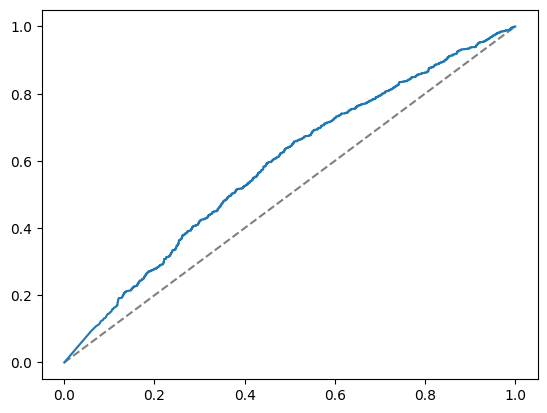

In [58]:
import numpy as np

fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, scores)

import matplotlib.pyplot as plt

plt.plot(np.arange(0, 2), np.arange(0, 2), linestyle="--", color="gray")
plt.plot(fpr, tpr)
plt.show()